In [1]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math
import os

def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    return df_master

def species_plot(df):
    df = df.replace("__ribosome", "free ribosomes")
    df = df.replace("TTT_charged", "charged tRNA")
    df = df.replace("TTT_uncharged", "uncharged tRNA")
    df_fil = df[(df.species == "charged tRNA") | (df.species == "free ribosomes")]
    g = sns.lineplot(x="time", y="protein", units="seed", hue="species", estimator=None, data=df_fil)
    g.get_legend().set_title(None)

In [2]:
from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

def get_average_protein(path_pref, time, max_seed, get_range=False):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    # get average species counts for all trials
    df_master = df_master.groupby(["time", "species"])["protein", "collisions", "moves"].mean().reset_index() #moves
    if time not in df_master["time"].values:
        time = take_closest(df_master["time"].values, time)
    if not get_range:
        df_master = df_master[(df_master.time == time)] 
    else:
        df_master = df_master[(df_master.time >= time - 100)]
        df_master["tRNA_ss"] = df_master[(df_master.species == "TTT_charged")]["protein"].mean()
        df_master["rib_ss"] = df_master[(df_master.species == "__ribosome")]["protein"].mean()
        df_master["rbs_ss"] = df_master[(df_master.species == "__proteinX_rbs")]["protein"].mean()
        df_master["ave_collisions"] = df_master[(df_master.species == "__ribosome")]["collisions"].mean()
        df_master["ave_moves"] = df_master[(df_master.species == "__ribosome")]["moves"].mean()
        df_master = df_master[(df_master.time == time)]
    df_master = df_master.replace("__ribosome", "ribosomes")
    return df_master

def concat_sims(path_pref, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    return df_master

In [9]:
from trnasimtools.serialize import SerializeSingleCodonSingleTranscript
from trnasimtools.simulate import SimulateSingleCodonSingleTranscript

In [13]:
rcParams['figure.figsize'] = [6, 5]

In [6]:
!mkdir ../yaml/august-14-2023
!mkdir ../output/august-14-2023

mkdir: cannot create directory ‘../yaml/august-14-2023’: File exists
mkdir: cannot create directory ‘../output/august-14-2023’: File exists


In [6]:
date = "october-10-2023"

### Re-running simulations from the single codon analysis with polymerase tracking turned on

## Finding analytical solutions for a single codon/single transcript system

This system consists of a fixed pool of mRNA transcripts, ribosomes, and a single type of tRNA. The rate of protein production depends exclusively on the steady-state concentrations of free ribosomes and charged tRNAs. We will attempt to find analytical solutions to calculate these quantities.

For tRNAs, the conversion between the charged/aminoacylated and uncharged form occurs instantaneously and irreversibly. Generically, this kind of reaction looks like

$A \rightarrow B$ with rate $k_{+}$ and $B \rightarrow A$ with rate $k_{-}$

The correspnding rate equation is

$\frac{d}{dt}\ a(t) = k_{-}b(t) - k_{+}a(t)$ 

and 

$\frac{d}{dt}\ b(t) = k_{+}a(t) - k_{-}b(t)$

Since total concentration is conserved, the concentrations can be derived by writing

$b(t) = T - a(t)$

Where $T$ is the total concentration of the reversible species. Equation 1 can then be re-written as   

$\frac{d}{dt}\ a(t) = k_{-}(T - a(t)) - k_{+}a(t)$

and

$\frac{d}{dt}\ a(t) = k_{-}T - (k_{+} + k_{-})a(t)$ 

The steady-state concentration satisfies 
$0 = k_{-}T - (k_{+} + k_{-})a(t)$

Solving gives
$$
a^{ss} = \frac {k_{-}T}{k_{+}+k_{-}} 
$$

The rate of consumption of charged tRNAs depends on the number of actively translating ribosomes (I think) -> so, the steady-state concentration of active ribosomes, and the ribosome "speed" constant. And then the rate of production depends on the charging rate constant. So if we let charged tRNAs be $a^{ss}$, swapping these in to the generic steady-state equation we have

$$
    \text{tRNA}_{\text{charged}} = \text{tRNA}_{\text{tot}} \times \frac{k_{\text{charge}}}{\text{rib}_{\text{active}} \times k_{\text{speed}} + k_{\text{charge}}}\
$$  

$$
\text{rib}_{\text{active}} = \text{rib}_{\text{tot}} \times \frac{k_{\text{bind}} \times N}{\frac{\text{tRNA}_{\text{charged}}}{N*L}\ + k_{bind} \times N}\
$$

Since these expressions depend on each other, we can subsitute one in for the other and solve the resulting quadratic for the closed-form solution. For ribosomes this is:

$$
    \text{rib}_{\text{active}} = \frac{-u - \sqrt{u^{2} + 4 \times \text{k}_{\text{charge}}\times \text{rib}_{\text{tot}}}}{-2\times\text{k}_{\text{speed}}}
$$

$$
   u = \text{rib}_{\text{tot}}\times \text{k}_{\text{speed}} - \text{k}_{\text{charge}} - \frac{\text{tRNA}_{\text{tot}}\times \text{k}_{\text{charge}}}{\text{k}_{\text{bind}}\times N^{2}\times L}
$$

(the closed form solution for tRNAs is similar)

As a sanity check, first I run one simulation where active ribosomes and tRNAs have non-trivial (not 0 or max) steady-states, and manually check the simulated ribosome steady state against abundances calculated from equation 2 (by just plugging in the value for tRNAs, rather than solving the system).

In [4]:
TS_COPY = 200
RBS_STRENGTH = 10000
TRNA_CHRG_RATE = 100
RB_COPY = 100
TOTAL_TRNA = 100
TIME_LIMIT = 500
TIME_STEP = 5
RB_SPEED = 3
LEN = 100

In [12]:
chrg_rates = [1.0, 2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 75.0, 100.0, 250.0, 500.0, 750.0, 1000.0, 2500.0, 5000.0, 7500.0, 10000.0]
for rate in chrg_rates:
    serializer = SerializeSingleCodonSingleTranscript(transcript_len=100,
                                                       transcript_copy_number=TS_COPY,
                                                       ribosome_binding_rate=RBS_STRENGTH,
                                                       ribosome_copy_number=RB_COPY,
                                                       total_trna=TOTAL_TRNA,
                                                       trna_charging_rate=rate
                                                       )
    serializer.serialize(f"../yaml/{date}")

In [14]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for seed in range(1, 4):
            cmd = f"python3 singlecodonsingletranscript.py ../yaml/{date}/{config} {seed} ../output/{date} {TIME_LIMIT} {TIME_STEP} {RB_SPEED}"
            stream.write(cmd)
            stream.write("\n")

In [7]:
chrg_rates = [2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 75.0, 100.0, 250.0, 500.0, 750.0, 1000.0, 2500.0, 5000.0, 7500.0, 10000.0]
df_master = None
for rate in chrg_rates:
    path = f"../output/{date}/single_codon_single_transcript_200_100_100_10000_{rate}"
    tmp = get_average_protein(path, 500, 3, get_range=True)
    tmp["charging_rate"] = rate
    df_master = tmp if df_master is None else df_master.append(tmp, ignore_index=True)
df_master

/tmp/ipykernel_2767289/3255776850.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_master = df_master.append(tmp, ignore_index=True)
/tmp/ipykernel_2767289/3255776850.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_master = df_master.append(tmp, ignore_index=True)
/tmp/ipykernel_2767289/3255776850.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_master = df_master.groupby(["time", "species"])["protein", "collisions", "moves"].mean().reset_index() #moves
/tmp/ipykernel_2767289/3255776850.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_master = df_master.append(tmp, ignore_index=True)
/tmp/ipykernel_2767289/325577685

,time,species,protein,collisions,moves,tRNA_ss,rib_ss,rbs_ss,ave_collisions,ave_moves,charging_rate
0,500.0,TTT_charged,0.000000,0.000000,0.000000,1.213675,3.115385,193.974359,3.820513,755.158120,2.5
1,500.0,TTT_uncharged,100.000000,0.000000,0.000000,1.213675,3.115385,193.974359,3.820513,755.158120,2.5
2,500.0,__proteinX_rbs,194.000000,0.000000,0.000000,1.213675,3.115385,193.974359,3.820513,755.158120,2.5
3,500.0,ribosomes,3.000000,0.000000,0.000000,1.213675,3.115385,193.974359,3.820513,755.158120,2.5
4,500.0,proteinX,1192.000000,0.000000,0.000000,1.213675,3.115385,193.974359,3.820513,755.158120,2.5
...,...,...,...,...,...,...,...,...,...,...,...
75,500.0,TTT_charged,99.000000,0.000000,0.000000,99.015152,79.750000,198.795455,32.068182,32097.227273,10000.0
76,500.0,TTT_uncharged,1.000000,0.000000,0.000000,99.015152,79.750000,198.795455,32.068182,32097.227273,10000.0
77,500.0,__proteinX_rbs,199.000000,0.000000,0.000000,99.015152,79.750000,198.795455,32.068182,32097.227273,10000.0
78,500.0,ribosomes,78.666667,19.333333,31302.333333,99.015152,79.750000,198.795455,32.068182,32097.227273,10000.0


In [8]:
df_rib_only = df_master[(df_master.species == "ribosomes")]
df_tRNA_only = df_master[(df_master.species == "TTT_charged")]
df_rbs_only = df_master[(df_master.species == "__proteinX_rbs")]

df_filtered = df_master[(df_master.species == "TTT_charged") | (df_master.species == "ribosomes")]
df_filtered = df_filtered.pivot(index = "charging_rate", columns = "species", values = "protein").reset_index()
df_filtered["tRNA predicted"] = (100 * df_filtered["charging_rate"]) / (((100 - df_filtered["ribosomes"]) * 3) + df_filtered["charging_rate"])
df_filtered = pd.melt(df_filtered, id_vars=["charging_rate"], value_vars=["TTT_charged", "tRNA predicted"])

df_rib_only["bound_rib_adj"] = (df_rib_only["ave_moves"] - (2 * df_rib_only["ave_collisions"])) / df_rib_only["ave_moves"]
df_rib_only["col_per_moves"] = df_rib_only["ave_collisions"] / df_rib_only["ave_moves"]

/tmp/ipykernel_2767289/1905605116.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rib_only["bound_rib_adj"] = (df_rib_only["ave_moves"] - (2 * df_rib_only["ave_collisions"])) / df_rib_only["ave_moves"]
/tmp/ipykernel_2767289/1905605116.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rib_only["col_per_moves"] = df_rib_only["ave_collisions"] / df_rib_only["ave_moves"]


In [9]:
def analytical_rib(charging_rate, SPEED):
    AVOGADRO = 6.02214076e23
    VOLUME = 8e-16
    binding_rate = RBS_STRENGTH / (AVOGADRO * VOLUME) * 200
    u = (binding_rate * TS_COPY * RB_COPY * SPEED) - (binding_rate * TS_COPY * charging_rate) - ((TOTAL_TRNA * charging_rate * SPEED)/ LEN)
    return 100 - ((-u - math.sqrt((u**2) + (4 * (binding_rate**2) * (TS_COPY**2) * RB_COPY * charging_rate * SPEED))) / (-2 * binding_rate * TS_COPY * SPEED))

In [11]:
def analytical_rib_bind_ss(charging_rate, SPEED, binding_site_ss, col_adj):
    AVOGADRO = 6.02214076e23
    VOLUME = 8e-16
    binding_rate = RBS_STRENGTH / (AVOGADRO * VOLUME) * 200
    u = (binding_rate * binding_site_ss * RB_COPY * SPEED * col_adj) - (binding_rate * binding_site_ss * charging_rate) - ((TOTAL_TRNA * charging_rate * SPEED * col_adj)/ LEN)
    return 100 - ((-u - math.sqrt((u**2) + (4 * (binding_rate**2) * (binding_site_ss**2) * RB_COPY * charging_rate * SPEED * col_adj))) / (-2 * binding_rate * binding_site_ss * SPEED * col_adj))

In [110]:
def analytical_trna(charging_rate, SPEED):
    AVOGADRO = 6.02214076e23
    VOLUME = 8e-16
    binding_rate = RBS_STRENGTH / (AVOGADRO * VOLUME) * 200
    u = ((charging_rate * TOTAL_TRNA * SPEED)/(LEN)) - (RB_COPY * binding_rate * TS_COPY * SPEED) - (charging_rate * binding_rate * TS_COPY)
    return (-u - math.sqrt((u**2) + ((4 * (charging_rate**2) * TOTAL_TRNA * binding_rate * TS_COPY * SPEED)/(LEN)))) / ((-2 * charging_rate * SPEED) / ((LEN)))

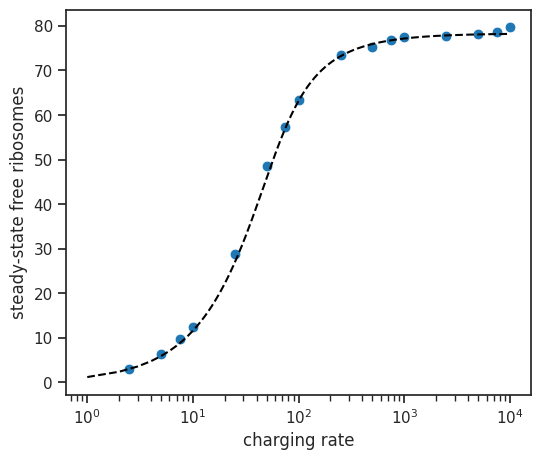

In [14]:
x = np.arange(1, 10000, 1)
rbs_ss = df_rbs_only["rbs_ss"].tolist()
adjustment = df_rib_only["bound_rib_adj"].tolist()

r = [analytical_rib(value, 3) for value in x]
r2 = [analytical_rib_bind_ss(rate, 3, sites, col_adj) for rate, sites, col_adj in zip(chrg_rates, rbs_ss, adjustment)]

sns.set_theme(style="ticks", palette=None)
g = sns.scatterplot(data=df_rib_only, x="charging_rate", y="rib_ss", s=60)
plt.xscale("log")
plt.ylabel("steady-state free ribosomes")
plt.xlabel("charging rate")

plt.plot(x, r, 'k--')
#plt.plot(chrg_rates, r2, 'b--')

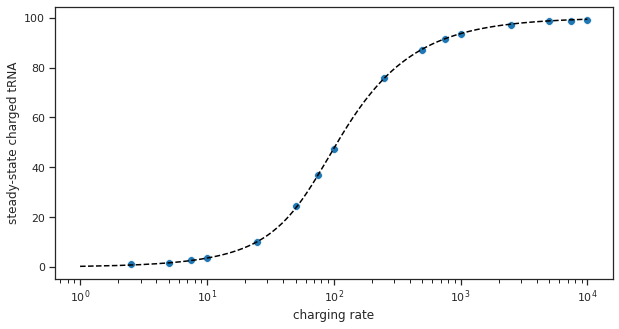

In [111]:
x = np.arange(1, 10000, 1)
t = [analytical_trna(value, 3) for value in x]
t2 = [analytical_trna(value, 1.7) for value in x]

sns.set_theme(style="ticks", palette=None)
g = sns.scatterplot(data=df_tRNA_only, x="charging_rate", y="tRNA_ss", s=60)
plt.xscale("log")
plt.ylabel("steady-state charged tRNA")
plt.xlabel("charging rate")

plt.plot(x, t, 'k--')

Text(0.5, 0, 'charging rate')

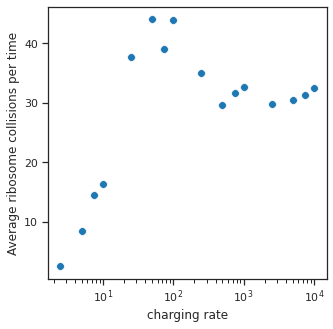

In [66]:
rcParams['figure.figsize'] = [5, 5]
#x = np.arange(1, 10000, 1)
#r = [analytical_rib(value, 3) for value in x]

sns.set_theme(style="ticks", palette=None)
g = sns.scatterplot(data=df_rib_only, x="charging_rate", y="ave_collisions", s=60)
plt.xscale("log")
plt.ylabel("Average ribosome collisions per time")
plt.xlabel("charging rate")

#plt.plot(x, y2, 'r--')
#plt.plot(x, r, 'k--')
#plt.plot(x, y5, 'b--')

Text(0.5, 0, 'charging rate')

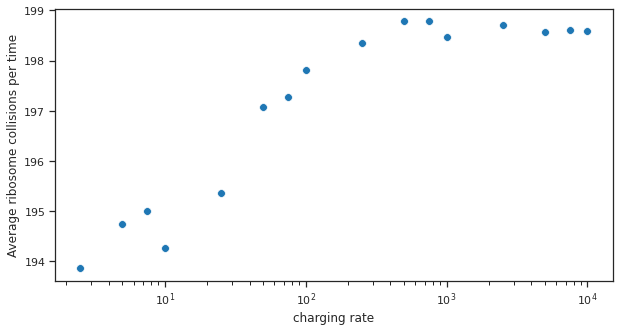

In [27]:
sns.set_theme(style="ticks", palette=None)
g = sns.scatterplot(data=df_rbs_only, x="charging_rate", y="rbs_ss", s=60)
plt.xscale("log")
plt.ylabel("Average ribosome collisions per time")
plt.xlabel("charging rate")

In [36]:
!mkdir ../yaml/october-10-2023
!mkdir ../output/october-10-2023

In [38]:
date = "october-10-2023"

In [40]:
chrg_rates = [1.0, 2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 75.0, 100.0, 250.0, 500.0, 750.0, 1000.0, 2500.0, 5000.0, 7500.0, 10000.0]
for rate in chrg_rates:
    serializer = SerializeSingleCodonSingleTranscript(transcript_len=100,
                                                       transcript_copy_number=TS_COPY,
                                                       ribosome_binding_rate=RBS_STRENGTH,
                                                       ribosome_copy_number=RB_COPY,
                                                       total_trna=TOTAL_TRNA,
                                                       trna_charging_rate=rate
                                                       )
    serializer.serialize(f"../yaml/{date}")

In [41]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for seed in range(1, 4):
            cmd = f"python3 singlecodonsingletranscript.py ../yaml/{date}/{config} {seed} ../output/{date} {TIME_LIMIT} {TIME_STEP} {RB_SPEED}"
            stream.write(cmd)
            stream.write("\n")

In [96]:
chrg_rates = [2.5, 5.0, 7.5, 10.0, 25.0, 50.0, 75.0, 100.0, 250.0, 500.0, 750.0, 1000.0, 2500.0, 5000.0, 7500.0, 10000.0]
df_master = None
for rate in chrg_rates:
    path = f"../output/{date}/single_codon_single_transcript_200_100_100_10000_{rate}"
    tmp = get_average_protein(path, 500, 3, get_range=True)
    tmp["charging_rate"] = rate
    df_master = tmp if df_master is None else df_master.append(tmp, ignore_index=True)
df_master

df_rib_only = df_master[(df_master.species == "ribosomes")]
df_rib_only["bound_rib_adj"] = (df_rib_only["ave_moves"] - (2 * df_rib_only["ave_collisions"])) / df_rib_only["ave_moves"]
df_rib_only["col_per_moves"] = df_rib_only["ave_collisions"] / df_rib_only["ave_moves"]
df_rib_only
#df_tRNA_only = df_master[(df_master.species == "TTT_charged")]

/tmp/ipykernel_39426/3255776850.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_master = df_master.groupby(["time", "species"])["protein", "collisions", "moves"].mean().reset_index() #moves
/tmp/ipykernel_39426/2508122890.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rib_only["bound_rib_adj"] = (df_rib_only["ave_moves"] - (2 * df_rib_only["ave_collisions"])) / df_rib_only["ave_moves"]
/tmp/ipykernel_39426/2508122890.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

,time,species,protein,collisions,moves,tRNA_ss,rib_ss,rbs_ss,ave_collisions,ave_moves,charging_rate,bound_rib_adj,col_per_moves
3,500.0,ribosomes,3.000000,0.000000,0.000000,1.213675,3.115385,193.974359,3.820513,755.158120,2.5,0.989882,0.005059
8,500.0,ribosomes,5.000000,10.000000,2435.000000,1.700980,6.372549,194.406863,10.004902,2129.906863,5.0,0.990605,0.004697
13,500.0,ribosomes,9.000000,12.500000,3635.500000,3.014286,9.647619,194.609524,14.866667,3559.890476,7.5,0.991648,0.004176
18,500.0,ribosomes,12.333333,18.666667,4833.000000,3.708333,12.517857,194.148810,20.291667,4668.351190,10.0,0.991307,0.004347
23,500.0,ribosomes,31.000000,35.666667,11138.000000,10.174603,28.888889,195.301587,35.825397,10871.761905,25.0,0.993409,0.003295
28,500.0,ribosomes,41.333333,64.666667,19072.000000,24.571429,48.634921,196.968254,45.269841,18724.968254,50.0,0.995165,0.002418
33,500.0,ribosomes,59.666667,34.000000,23514.666667,36.761905,57.317460,197.412698,40.904762,23612.730159,75.0,0.996535,0.001732
38,500.0,ribosomes,68.333333,78.333333,26013.666667,47.539683,63.317460,197.904762,40.333333,25184.365079,100.0,0.996797,0.001602
43,500.0,ribosomes,72.000000,17.666667,30263.666667,75.634921,73.555556,198.444444,34.000000,29676.841270,250.0,0.997709,0.001146
48,500.0,ribosomes,74.333333,16.333333,31456.666667,87.126984,75.269841,198.730159,29.317460,31496.619048,500.0,0.998138,0.000931


Text(0.5, 0, 'charging rate')

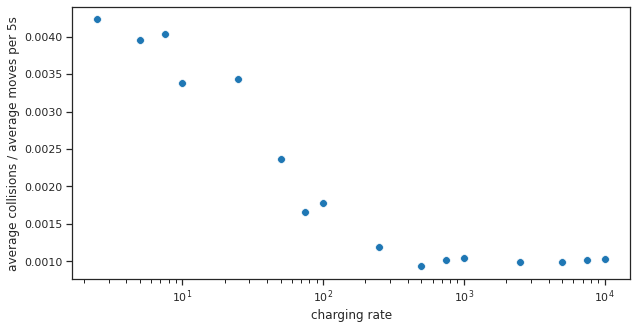

In [72]:
rcParams['figure.figsize'] = [10, 5]
sns.set_theme(style="ticks", palette=None)
g = sns.scatterplot(data=df_rib_only, x="charging_rate", y="col_per_moves", s=60)
plt.xscale("log")
plt.ylabel("average collisions / average moves per 5s")
plt.xlabel("charging rate")

In [120]:
rate = 25.0
path = f"../output/{date}/single_codon_single_transcript_200_100_100_10000_{rate}"
sims = concat_sims(path, 3)
sims_fil = sims[(sims.species == "__ribosome")]
sims_fil = sims_fil[sims_fil.time > 200]

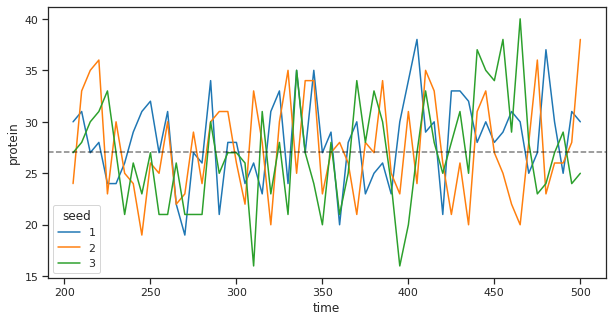

In [121]:
g = sns.lineplot(data=sims_fil, x="time", y="protein", hue="seed")
n = analytical_rib(rate, 3)
plt.gca().axhline(n, ls='--', color="black", alpha=0.5)